In [ ]:
import pandas as pd
import librosa
import soundfile
import os, glob, pickle
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings('ignore')

In [ ]:
import os
for dirname, _, filenames in os.walk('/content/drive'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Output streaming akan dipotong hingga 5000 baris terakhir.
/content/drive/MyDrive/Google Maps_Amanda Betania Maritza-F55122032/Google-Maps-2018-master/app/build/intermediates/merged_res/debug/values-v26_values-v26.arsc.flat
/content/drive/MyDrive/Google Maps_Amanda Betania Maritza-F55122032/Google-Maps-2018-master/app/build/intermediates/merged_res/debug/values-b+sr+Latn_values-b+sr+Latn.arsc.flat
/content/drive/MyDrive/Google Maps_Amanda Betania Maritza-F55122032/Google-Maps-2018-master/app/build/intermediates/merged_res/debug/values-es-rUS_values-es-rUS.arsc.flat
/content/drive/MyDrive/Google Maps_Amanda Betania Maritza-F55122032/Google-Maps-2018-master/app/build/intermediates/merged_res/debug/values-ko_values-ko.arsc.flat
/content/drive/MyDrive/Google Maps_Amanda Betania Maritza-F55122032/Google-Maps-2018-master/app/build/intermediates/merged_res/debug/values-sw600dp-v13_values-sw600dp-v13.arsc.flat
/content/drive/MyDrive/Google Maps_Amanda Betania Maritza-F55122032/Google-Maps-2018

In [ ]:
def extract_feature(file_name):
    X, sample_rate = librosa.load(file_name)
    stft=np.abs(librosa.stft(X))
    result=np.array([])

    mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    result=np.hstack((result, mfccs))

    chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    result=np.hstack((result, chroma))

    mel=np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)
    result=np.hstack((result, mel))

    return result

In [ ]:
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

def gender(g):
    if int(g[0:2]) % 2 == 0:
        return 'female'
    else:
        return 'male'

In [ ]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (9,6), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
def load_data(test_size=0.2):
    x,y=[],[]
    for file in tqdm(glob.glob("/content/drive/My Drive/audio/audio_speech_actors_01-24/Actor_*/*.wav")):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]] + '_' + gender(file_name.split("-")[-1])
        feature=extract_feature(file)
        x.append(feature)
        y.append(emotion)
    return train_test_split(np.array(x), y, test_size=test_size, random_state=1)

In [ ]:
X_train, X_val, y_train, y_val = load_data()

print((X_train.shape[0], X_val.shape[0]))

100%|██████████| 1440/1440 [16:35<00:00,  1.45it/s]

(1152, 288)


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [ ]:
print(f'Features extracted: {X_train.shape[1]}')

Features extracted: 180


In [ ]:
from sklearn.neural_network import MLPClassifier

model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)
model_history=model.fit(X_train,y_train)
print(model.score(X_train, y_train))

1.0


In [ ]:
y_pred=model.predict(X_val)
print(model.score(X_val, y_val))

0.6631944444444444


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
# print(confusion_matrix(y_test,y_pred))
print(classification_report(y_val,y_pred))

                  precision    recall  f1-score   support

    angry_female       0.57      0.65      0.60        20
      angry_male       0.94      0.73      0.82        22
     calm_female       0.77      0.89      0.83        19
       calm_male       0.83      0.67      0.74        15
  disgust_female       0.54      0.58      0.56        24
    disgust_male       0.58      0.44      0.50        16
  fearful_female       0.78      0.82      0.80        17
    fearful_male       0.42      0.59      0.49        17
    happy_female       0.71      0.68      0.70        22
      happy_male       0.61      0.56      0.58        25
  neutral_female       0.86      0.60      0.71        10
    neutral_male       0.54      0.64      0.58        11
      sad_female       0.82      0.93      0.87        15
        sad_male       0.50      0.67      0.57        18
surprised_female       0.78      0.70      0.74        20
  surprised_male       0.73      0.47      0.57        17

        accu

In [ ]:
from sklearn.metrics import confusion_matrix
c = confusion_matrix(y_val, y_pred)
c

array([[13,  0,  1,  0,  4,  0,  0,  0,  1,  0,  0,  0,  0,  0,  1,  0],
       [ 1, 16,  0,  0,  0,  1,  1,  1,  0,  2,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 17,  0,  0,  0,  0,  0,  0,  0,  1,  0,  1,  0,  0,  0],
       [ 0,  0,  0, 10,  0,  0,  0,  0,  0,  1,  0,  3,  0,  1,  0,  0],
       [ 5,  0,  0,  0, 14,  0,  0,  0,  2,  0,  0,  0,  0,  0,  3,  0],
       [ 2,  1,  0,  1,  0,  7,  0,  2,  0,  0,  0,  0,  0,  2,  0,  1],
       [ 0,  0,  0,  0,  0,  0, 14,  0,  1,  0,  0,  0,  2,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 10,  0,  2,  0,  0,  0,  4,  0,  1],
       [ 0,  0,  0,  0,  3,  0,  3,  0, 15,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  1,  2,  0,  4,  0, 14,  0,  1,  0,  1,  0,  1],
       [ 0,  0,  2,  0,  2,  0,  0,  0,  0,  0,  6,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  1,  0,  0,  0,  7,  0,  2,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0, 14,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  5,  0,  1,  0,

In [ ]:
# using numpy.unique
import numpy as np

# function to get unique values
def unique(list1):
    x = np.array(list1)
    print(np.unique(x))

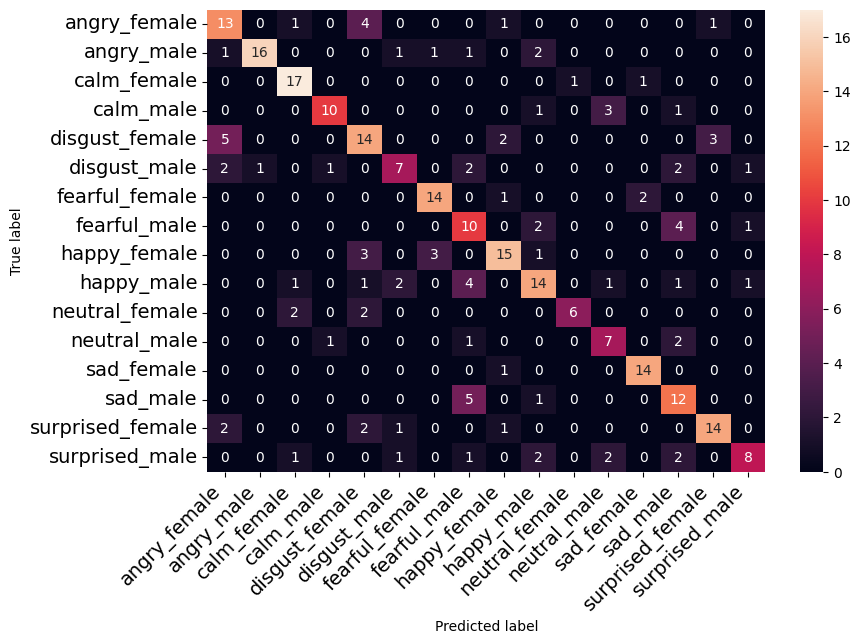

In [ ]:
class_names=sorted(set(y_val))
print_confusion_matrix(c, class_names)

In [ ]:
df=pd.DataFrame({'Actual': y_val, 'Predicted':y_pred})
df

,Actual,Predicted
0,surprised_male,happy_male
1,neutral_female,neutral_female
2,sad_female,sad_female
3,happy_male,happy_male
4,disgust_female,surprised_female
...,...,...
283,sad_female,sad_female
284,sad_female,sad_female
285,angry_female,angry_female
286,sad_male,happy_male


In [ ]:
def train_and_evaluate_classifier(classifier, X_train, y_train, X_val, y_val):
    # Fit the model
    model = classifier.fit(X_train, y_train)

    # Make predictions on the validation set
    y_pred = model.predict(X_val)

    # Print classification report
    print(classification_report(y_val, y_pred))

    # Plot confusion matrix
    c = confusion_matrix(y_val, y_pred)
    class_names = sorted(set(y_val))
    print_confusion_matrix(c, class_names)

    return model

In [ ]:
# Load and preprocess data
X_train, X_val, y_train, y_val = load_data()

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)


100%|██████████| 1440/1440 [01:49<00:00, 13.18it/s]


                  precision    recall  f1-score   support

    angry_female       0.67      0.70      0.68        20
      angry_male       0.90      0.82      0.86        22
     calm_female       0.76      0.84      0.80        19
       calm_male       0.85      0.73      0.79        15
  disgust_female       0.64      0.67      0.65        24
    disgust_male       0.64      0.44      0.52        16
  fearful_female       0.78      0.82      0.80        17
    fearful_male       0.39      0.53      0.45        17
    happy_female       0.70      0.64      0.67        22
      happy_male       0.73      0.64      0.68        25
  neutral_female       0.70      0.70      0.70        10
    neutral_male       0.58      0.64      0.61        11
      sad_female       0.83      0.67      0.74        15
        sad_male       0.43      0.67      0.52        18
surprised_female       0.80      0.80      0.80        20
  surprised_male       0.75      0.53      0.62        17

        accu

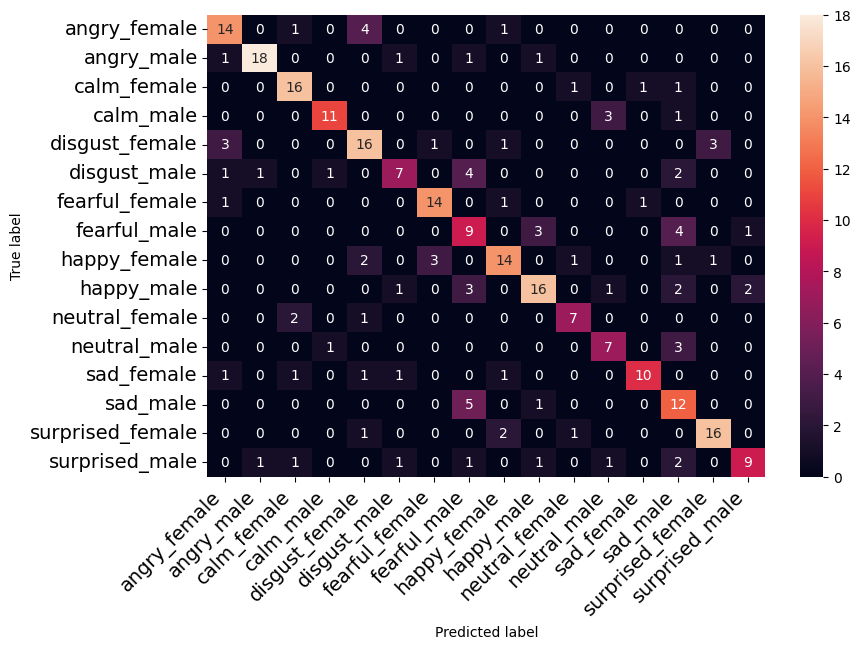

In [ ]:
# Train and evaluate MLP Classifier
mlp_model = train_and_evaluate_classifier(
    MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500),
    X_train, y_train, X_val, y_val
)

                  precision    recall  f1-score   support

    angry_female       0.32      0.50      0.39        20
      angry_male       0.52      0.50      0.51        22
     calm_female       0.59      0.84      0.70        19
       calm_male       0.60      0.80      0.69        15
  disgust_female       0.39      0.38      0.38        24
    disgust_male       0.31      0.31      0.31        16
  fearful_female       0.47      0.47      0.47        17
    fearful_male       0.41      0.41      0.41        17
    happy_female       0.33      0.23      0.27        22
      happy_male       0.70      0.28      0.40        25
  neutral_female       0.18      0.20      0.19        10
    neutral_male       0.57      0.73      0.64        11
      sad_female       0.46      0.40      0.43        15
        sad_male       0.53      0.50      0.51        18
surprised_female       0.55      0.60      0.57        20
  surprised_male       0.50      0.41      0.45        17

        accu

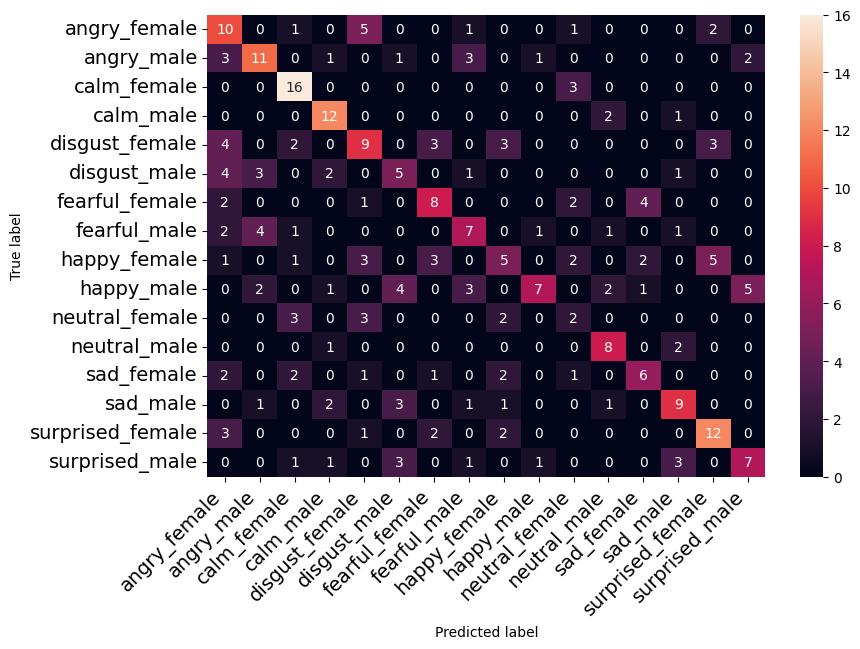

In [ ]:
# Train and evaluate k-NN Classifier
knn_model = train_and_evaluate_classifier(
    KNeighborsClassifier(n_neighbors=5),
    X_train, y_train, X_val, y_val
)

                  precision    recall  f1-score   support

    angry_female       0.33      0.20      0.25        20
      angry_male       0.87      0.59      0.70        22
     calm_female       0.45      0.95      0.61        19
       calm_male       0.21      0.53      0.30        15
  disgust_female       0.28      0.29      0.29        24
    disgust_male       0.25      0.31      0.28        16
  fearful_female       0.25      0.06      0.10        17
    fearful_male       0.27      0.18      0.21        17
    happy_female       0.50      0.18      0.27        22
      happy_male       0.23      0.12      0.16        25
  neutral_female       0.13      0.20      0.16        10
    neutral_male       0.21      0.45      0.29        11
      sad_female       0.25      0.13      0.17        15
        sad_male       0.07      0.11      0.09        18
surprised_female       0.30      0.15      0.20        20
  surprised_male       0.19      0.18      0.18        17

        accu

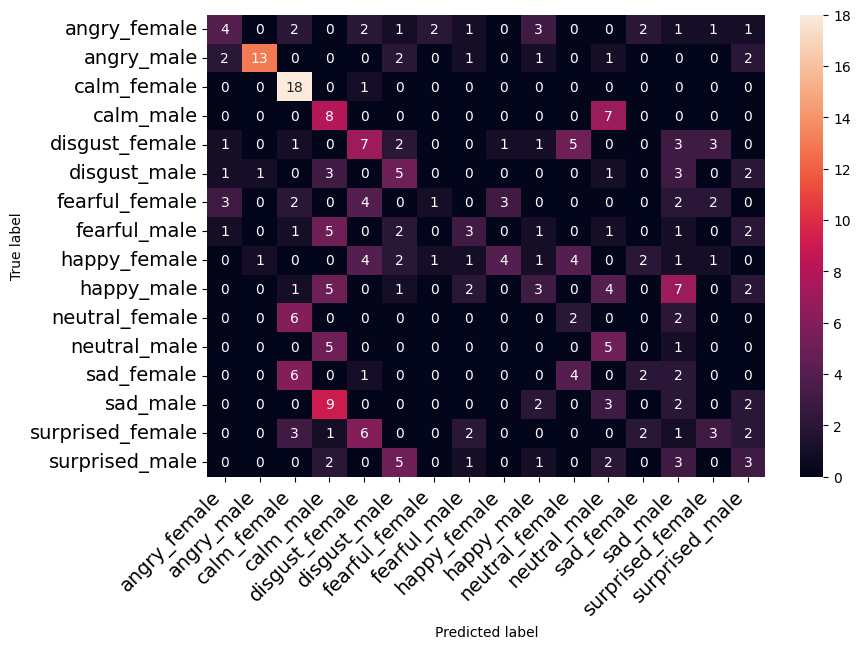

In [ ]:
# Train and evaluate Naive Bayes Classifier
nb_model = train_and_evaluate_classifier(
    GaussianNB(),
    X_train, y_train, X_val, y_val
)

                  precision    recall  f1-score   support

    angry_female       0.60      0.75      0.67        20
      angry_male       0.82      0.82      0.82        22
     calm_female       0.76      0.84      0.80        19
       calm_male       0.56      0.60      0.58        15
  disgust_female       0.50      0.50      0.50        24
    disgust_male       0.50      0.50      0.50        16
  fearful_female       0.79      0.65      0.71        17
    fearful_male       0.53      0.53      0.53        17
    happy_female       0.74      0.64      0.68        22
      happy_male       0.75      0.48      0.59        25
  neutral_female       0.44      0.40      0.42        10
    neutral_male       0.40      0.36      0.38        11
      sad_female       0.72      0.87      0.79        15
        sad_male       0.41      0.72      0.52        18
surprised_female       0.65      0.65      0.65        20
  surprised_male       0.78      0.41      0.54        17

        accu

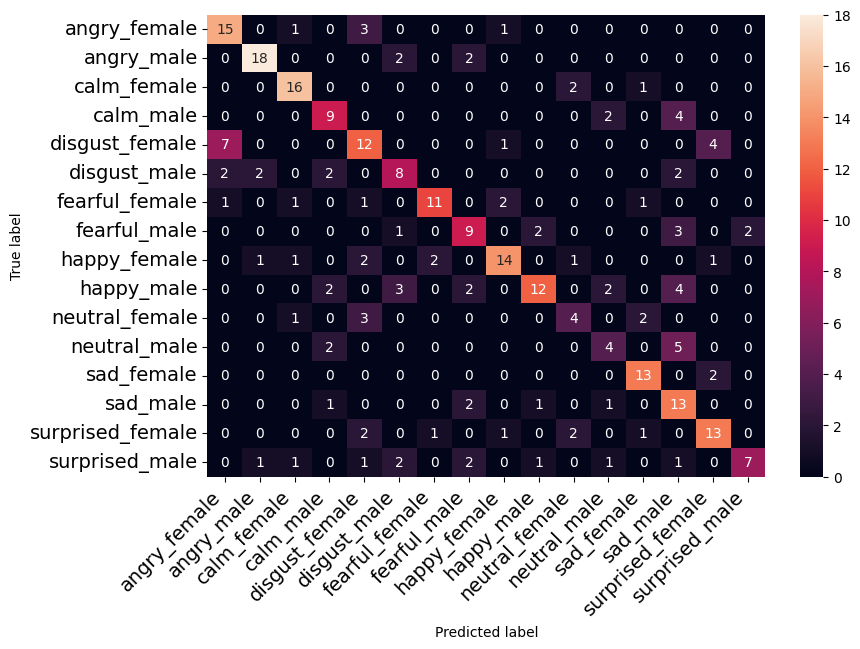

In [ ]:
# Train and evaluate SVM Classifier
svm_model = train_and_evaluate_classifier(
    SVC(kernel='linear', C=1),
    X_train, y_train, X_val, y_val
)

                  precision    recall  f1-score   support

    angry_female       0.60      0.60      0.60        20
      angry_male       0.86      0.82      0.84        22
     calm_female       0.72      0.95      0.82        19
       calm_male       0.45      1.00      0.62        15
  disgust_female       0.54      0.54      0.54        24
    disgust_male       0.42      0.50      0.46        16
  fearful_female       0.62      0.59      0.61        17
    fearful_male       0.45      0.29      0.36        17
    happy_female       0.64      0.32      0.42        22
      happy_male       0.53      0.32      0.40        25
  neutral_female       0.75      0.30      0.43        10
    neutral_male       1.00      0.27      0.43        11
      sad_female       0.52      0.87      0.65        15
        sad_male       0.52      0.61      0.56        18
surprised_female       0.48      0.60      0.53        20
  surprised_male       0.67      0.59      0.62        17

        accu

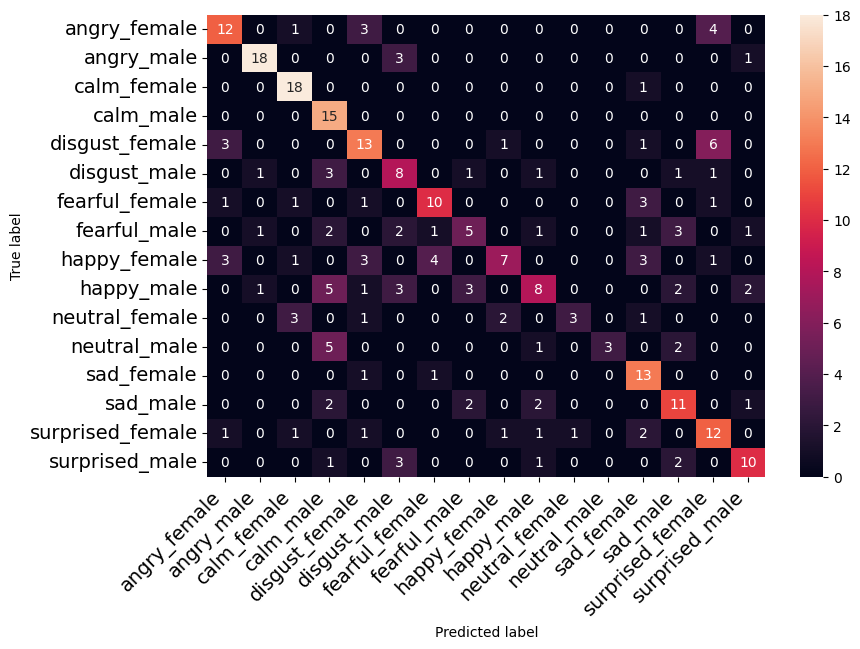

In [ ]:
# Train and evaluate Random Forest Classifier
rf_model = train_and_evaluate_classifier(
    RandomForestClassifier(n_estimators=100, random_state=1),
    X_train, y_train, X_val, y_val
)

In [ ]:
def accuracy (classifier, X_train, y_train, X_val, y_val):
    # Fit the model
    model = classifier.fit(X_train, y_train)

    # Evaluate on training set
    train_accuracy = model.score(X_train, y_train)
    print(f'Training Accuracy = {train_accuracy}')

    # Evaluate on validation set
    val_accuracy = model.score(X_val, y_val)
    print(f'Validation Accuracy = {val_accuracy}')

    return train_accuracy, val_accuracy

In [ ]:
print(f'Akurasi MLP : ')
mlp_train_accuracy, mlp_val_accuracy = accuracy(
    MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500),
    X_train, y_train, X_val, y_val
)

print(f'')

print(f'Akurasi K-NN : ')
knn_train_accuracy, knn_val_accuracy = accuracy(
    KNeighborsClassifier(n_neighbors=5),
    X_train, y_train, X_val, y_val
)

print(f'')

print(f'Akurasi Naive Bayes : ')
nb_train_accuracy, nb_val_accuracy = accuracy(
    GaussianNB(),
    X_train, y_train, X_val, y_val
)

print(f'')

print(f'Akurasi SVM : ')
svm_train_accuracy, svm_val_accuracy = accuracy(
    SVC(kernel='linear', C=1),
    X_train, y_train, X_val, y_val
)

print(f'')

print(f'Akurasi Random Forest : ')
rf_train_accuracy, rf_val_accuracy = accuracy(
    RandomForestClassifier(n_estimators=100, random_state=1),
    X_train, y_train, X_val, y_val
)

Akurasi MLP : 
Training Accuracy = 1.0
Validation Accuracy = 0.6701388888888888

Akurasi K-NN : 
Training Accuracy = 0.7621527777777778
Validation Accuracy = 0.4652777777777778

Akurasi Naive Bayes : 
Training Accuracy = 0.3454861111111111
Validation Accuracy = 0.2881944444444444

Akurasi SVM : 
Training Accuracy = 0.9574652777777778
Validation Accuracy = 0.6180555555555556

Akurasi Random Forest : 
Training Accuracy = 1.0
Validation Accuracy = 0.5763888888888888


In [ ]:
models = ['MLP', 'k-NN', 'Naive Bayes', 'SVM', 'Random Forest']
train_accuracies = [mlp_train_accuracy, knn_train_accuracy, nb_train_accuracy, svm_train_accuracy, rf_train_accuracy]
val_accuracies = [mlp_val_accuracy, knn_val_accuracy, nb_val_accuracy, svm_val_accuracy, rf_val_accuracy]

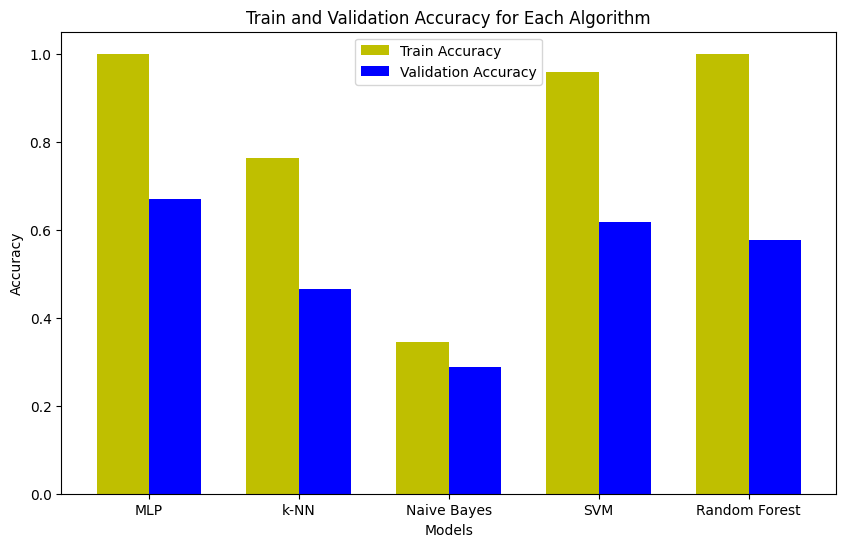

In [ ]:
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(models))

plt.bar(index, train_accuracies, bar_width, label='Train Accuracy', color='y', align='center')
plt.bar(index + bar_width, val_accuracies, bar_width, label='Validation Accuracy', color='b', align='center')

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy for Each Algorithm')
plt.xticks(index + bar_width / 2, models)
plt.legend()
plt.show()